<a href="https://colab.research.google.com/github/alekswheeler/datasci_home_work/blob/main/Especifica%C3%A7%C3%A3o_2024_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho Prático

O objetivo geral deste trabalho é praticar os conceitos discutidos em sala de aula, principalmente: representação e pré-processamento de dados textuais; redução de dimensionalidade e algoritmos de agrupamento.

## Conjunto de Dados

Para esse trabalho utilizaremos um conjunto de dados de filmes. Os dados foram obtidos de várias fontes, incluindo IMDB.

O conjunto de dados que vocês deverão usar encontra-se no AVA da disciplina. Os dados estão organizados um arquivo (`.csv`) com as seguintes colunas:

* **genres** - gêneros a que um filme pertence. Veja que um filme pode estar associado a mais de um gênero (`str`);
* **sinopse** - sinopse do filme (`str`);
* **startYear** - ano de lançamento do filme (`int`);
* **primaryTitle** - título do filme (`str`);
* **runtimeMinutes** - duração do filme, em minutos (`int`);
* **averageRating** - média das avaliações do filme (`float`);
* **numVotes** - número de avaliações do filme (`int`);
* **actors_names** - atores/atrizes principais (`str`);
* **directors_names** - diretores(as) do filme (`str`).

**Observação:** esse conjunto de dados é uma versão transformada dos dados originais. Por exemplo, gêneros muito populares ou raros foram removidos.

**ATENÇÃO**
É possível que seu computador não consiga lidar com o conjunto de dados completo. Se for o caso, faça uma amostra aleatória de filmes do conjunto de dados. Deixe claro o processo de amostragem, o tamanho das amostras finais que considerou no trabalho e as especificações do computador utilizado.

Os comandos abaixo mostram como os dados podem ser obtidos e carregados em um `DataFrame`.

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1AeYgV89TmYvNC__RDXr8hS0P6WOsChWg' -O filmes.csv

--2025-02-20 02:57:29--  https://docs.google.com/uc?export=download&id=1AeYgV89TmYvNC__RDXr8hS0P6WOsChWg
Resolving docs.google.com (docs.google.com)... 142.250.107.138, 142.250.107.101, 142.250.107.102, ...
Connecting to docs.google.com (docs.google.com)|142.250.107.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1AeYgV89TmYvNC__RDXr8hS0P6WOsChWg&export=download [following]
--2025-02-20 02:57:29--  https://drive.usercontent.google.com/download?id=1AeYgV89TmYvNC__RDXr8hS0P6WOsChWg&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.107.132, 2607:f8b0:400e:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.107.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11380332 (11M) [application/octet-stream]
Saving to: ‘filmes.csv’

filmes.csv          100%[===================>]  10.85M  57.3MB/s   

In [ ]:
import pandas as pd
df = pd.read_csv("filmes.csv")

In [ ]:
df.head()
a = df['sinopse']

## Objetivo

Vocês deverão utilizar aprendizado não supervisionado (neste caso, agrupamento) para investigar se há relação entre a **sinopse** de um filme e o(s) **gênero(s)** a que pertence.

De forma mais específica, vocês deverão agrupar os filmes de acordo suas sinopses e, após isso, verificar a distribuição dos gêneros em cada grupo. Ou seja, se os filmes pertencentes ao mesmo grupo possuem o(s) mesmo(s) gênero(s) ou se as distribuições de gêneros de grupos diferentes são distintas.

## Trabalho

## Preparando os dados

Antes de fazer o pré-processamento de dados a ideia é que vamos dividir a base de dados em pedaços menores mantendo a proporção da base de dados original ([StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)).

In [ ]:
X = df.drop(columns=['genres'])
y = df['genres']

In [ ]:
generos = y.unique()

### Separando os dados em folds estratificados

Essa decisão foi tomada pois os dados originais continham uma quantidade muito grande de dados o que implica em mais custo de processamento (e de tempo). Para evitar viés, escolhemos uma amostra estratificada que mantém a proporção original dos dados na amostra. A amostra escolhida é sempre aleatória, isso ajuda a não fazer overfiting no trabalho otimizando o algoritmo para uma mesma amostra.

**O que poderia melhorar**


Poderíamos usar validação cruzada estratificada para decidir hiperparâmetros e avaliar o classificador.

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

SEED = 42
np.random.seed(SEED)

n_folds = 4

# Dividindo em 10 Folds estratificados
skf = StratifiedKFold(n_splits=n_folds)

# Guardar todos os folds
folds = list(skf.split(X, y))

# Escolher um fold aleatório
random_fold = np.random.RandomState(SEED).choice(len(folds))

# Separar os dados do fold escolhido
train_idx, test_idx = folds[random_fold]

# dados de treino
rand_X, rand_y = X.iloc[test_idx], y.iloc[test_idx]

#dados de validação
rand_X_test, rand_y_test = X.iloc[test_idx], y.iloc[test_idx];

# Pegando apenas a característica sinopse da amostra
rand_X = rand_X['sinopse']
rand_X_test = rand_X_test['sinopse'];

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


### Criando matriz de tokens para trabalhar com TF-IDF


Seguimos a sequência sugeridada em aula de usar tokenização, stopwords e o stemmer. Usamos a biblioteca mostrada em aula nltk para o stemmer e para a tokenização. O Stemmer foi muito importante junto com o min_df para reduzir a quantidade de palavras geradas.

A escolha do min_df: Testamos alguns valores e descobrimos que o min_df não pode ser muito alto pois assim não sobra nenhuma palavra. E também não pode ser muito baixo pois não trás nehum ganho significativo. Assim escolhemos o valor 0.001 pois trouxe uma redução no conjunto de palavras do TF-IDF sem excluir palvras muito recorrentes. Validamos olhando as palavras no TF-IDF, algumas eram de outros idiomas e com acentos, elas não eram removidas pelas técnicas anteriores de tokenização, mas quando usamos min_df essas palavras sumiram indicando que eram de poucos documentos ou de apenas um.

Decidimos também usar a biblioteca Spacy pois ela traz as feature de identificar o idioma da sinopse para fazer a tokenização, usar o Stemmer e lemantização. Isso também fez uma melhoria significatica nos dados gerados.

Para stopwords usamos a biblioteca nltk mesmo.

In [ ]:
!pip install -U spacy
!pip install matplotlib scipy scikit-learn
!pip install langdetect

# Baixando os modelos
!python -m spacy download en_core_web_sm
!python -m spacy download es_core_news_sm
!python -m spacy download de_core_news_sm
!python -m spacy download fr_core_news_sm
;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 56.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 47.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 49.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('

''

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from langdetect import detect
import spacy
import nltk

# Baixando as stop words do NLTK (apenas na primeira execução)
nltk.download('stopwords')

# Combina todas as stop words de todos os idiomas disponíveis no NLTK
all_stop_words = set()
for lang in stopwords.fileids():
    all_stop_words.update(stopwords.words(lang))

# Inicializando o PorterStemmer
stemmer = PorterStemmer()

# Carregando modelos do SpaCy para diferentes idiomas
spacy_models = {
    'en': spacy.load('en_core_web_sm'),
    'es': spacy.load('es_core_news_sm'),
    'de': spacy.load('de_core_news_sm'),
    'fr': spacy.load('fr_core_news_sm')
}

def tokenize_stem(text):
    try:
        # Detecta o idioma do texto
        lang = detect(text)
    except:
        lang = 'en'  # Padrão para inglês caso não detecte

    # Usa o modelo SpaCy correspondente ao idioma
    nlp = spacy_models.get(lang, spacy_models['en'])
    doc = nlp(text)

    # Tokenização, Lematização e Remoção de Stop Words (tudo junto com SpaCy)
    tokens = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]

    # Remove as stop words multilíngues
    tokens = [word for word in tokens if word not in all_stop_words]

    # Aplica stemming usando o PorterStemmer
    tokens = [stemmer.stem(word) for word in tokens]

    return tokens


# Criando o TfidfVectorizer com Stemming e Remoção de Números
vectorizer = TfidfVectorizer(
    min_df = 0.001,
    tokenizer=tokenize_stem,  # Usa a função personalizada
    token_pattern=None  # Ignorado quando usamos tokenizer personalizado
)

# Ajusta o vectorizer no conjunto completo (ou apenas no treino, se preferir)
vectorizer.fit(rand_X)

# Transforma os dados de rand_X
rand_X_tfidf = vectorizer.transform(rand_X)

tfidf_dataframe = pd.DataFrame(rand_X_tfidf.todense(), columns = vectorizer.get_feature_names_out())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
tfidf_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7589 entries, 0 to 7588
Columns: 2667 entries, abandon to zone
dtypes: float64(2667)
memory usage: 154.4 MB


### Usando PCA

Escolhemos a quantidade de componentes do PCA observando o gráfico mostrado em aula, percebemos que se usamos 2000 colunas ainda temos aproximadamente 90% dos dados, então essa foi a escolha.

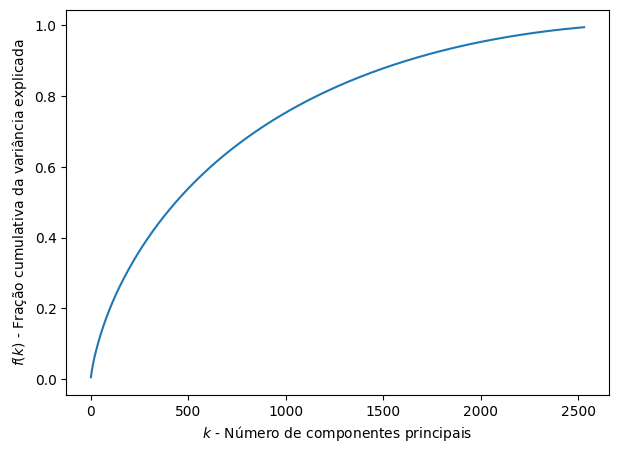

In [ ]:
# Usando PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_wine
import pandas as pd

pca = PCA(n_components = 2530)
pca.fit(tfidf_dataframe)

#@title
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(7, 5))
plt.plot([i for i in range(1, pca.n_components + 1)], np.cumsum(pca.explained_variance_ratio_))
plt.xlabel(r'$k$ - Número de componentes principais')
plt.ylabel(r'$f(k)$ - Fração cumulativa da variância explicada');

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(n_components = 2000)
X2 = pca.fit_transform(tfidf_dataframe)

### Usando agrupamento hierárquico nos rótulos das classes

Percemos que algumas classes são multigênero por exemplo: 'Romance, Action'. Inicialmente pensamos em usar apenas o primeiro gênero de cada classe mas isso não gerou grupos satisfatórios. Decidimos agrupar observando a similaridade dessas classes. Abaixo usamos um agrupamento hieráquico e no "olhometro" as classes estão bem homogênas (todas ou a maioria das classes no grupo tem os gêneros em comum).

In [ ]:
generos = rand_y.unique()
generos

array(['Sport,Sci-Fi,Action', 'Sport,Crime', 'Sci-Fi,Crime,Action',
       'Sport,Musical', 'Romance,Horror,Sci-Fi', 'Sport,Romance',
       'Romance,Biography', 'Romance,Crime', 'Crime,Biography',
       'Musical,Family', 'Sci-Fi,Family', 'Action,Family',
       'Crime,Sci-Fi,Horror', 'Musical,Sci-Fi', 'Horror,Family',
       'Musical,Romance,Action', 'Biography,Family', 'Romance,Sci-Fi',
       'Romance', 'Sport,Action', 'Musical,Crime', 'Musical,Romance',
       'Biography', 'Crime', 'Romance,Family', 'Sport', 'Sport,Family',
       'Sci-Fi,Action', 'Sport,Sci-Fi', 'Biography,Action', 'Musical',
       'Sport,Biography', 'Crime,Biography,Action', 'Musical,Horror',
       'Sci-Fi,Horror', 'Sport,Crime,Action', 'Family', 'Crime,Action',
       'Romance,Horror', 'Action', 'Sci-Fi,Horror,Action', 'Crime,Horror',
       'Musical,Biography', 'Romance,Action', 'Sci-Fi', 'Crime,Family',
       'Crime,Horror,Action', 'Horror', 'Musical,Action', 'Horror,Action',
       'Sci-Fi,Crime', 'Sport,

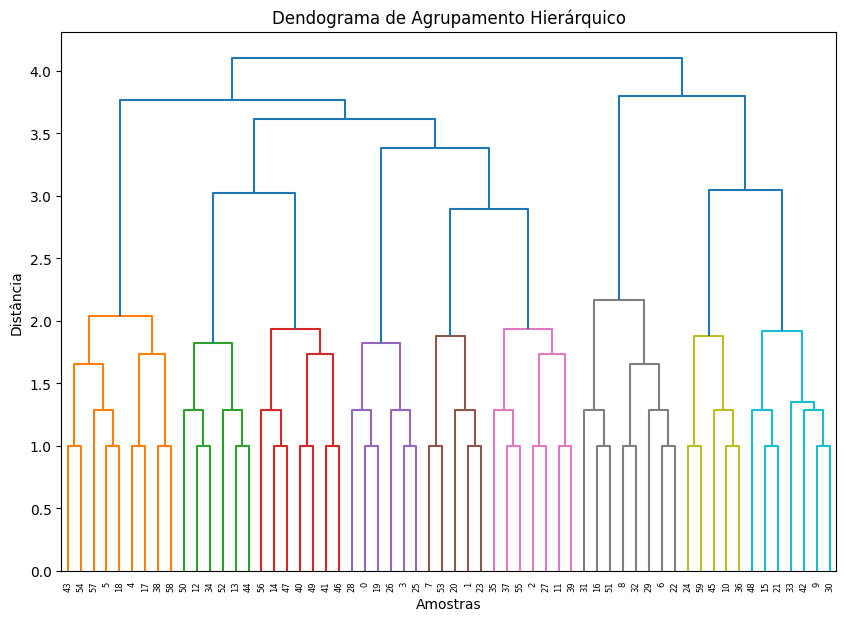

In [ ]:
# usando aglomerativo para decidir os grupos
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

# Quebrando os gêneros por vírgula para cada filme
generos_split = [g.split(',') for g in generos]

# Aplicando MultiLabelBinarizer para One-Hot Encoding
mlb = MultiLabelBinarizer()
generos_encoded = mlb.fit_transform(generos_split)

# Convertendo para DataFrame para melhor visualização
df_generos = pd.DataFrame(generos_encoded, columns=mlb.classes_)

num_clusters = 7

# Calculando as ligações para o dendograma
hierarchical_model = AgglomerativeClustering(n_clusters=num_clusters,linkage='ward')
Z = linkage(generos_encoded, method='ward')

# Plotando o dendograma
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendograma de Agrupamento Hierárquico')
plt.xlabel('Amostras')
plt.ylabel('Distância')
plt.show()

Aqui mostramos os grupos que foram definidos com base no agrupamento hierárquico. Também usamos essa informação para modificar o vetor de classes reais (y_true) substituindo o nome da classe pelo cluster correspondente.

In [ ]:
clusters = hierarchical_model.fit_predict(generos_encoded)

# Adicionando os rótulos dos clusters ao DataFrame original
df_generos['Cluster'] = clusters
df_generos['Original'] = generos  # Mantendo os gêneros originais para referência

# Exibindo as classes agrupadas
print("\nAgrupamento de gêneros por cluster:")
for i in range(num_clusters):
    print(f"\nCluster {i}:")
    print(df_generos[df_generos['Cluster'] == i]['Original'].values)


Agrupamento de gêneros por cluster:

Cluster 0:
['Crime,Sci-Fi,Horror' 'Musical,Sci-Fi' 'Horror,Family' 'Sci-Fi,Horror'
 'Sci-Fi,Horror,Action' 'Crime,Horror' 'Sci-Fi' 'Crime,Horror,Action'
 'Horror' 'Horror,Action' 'Sci-Fi,Crime' 'Sci-Fi,Biography'
 'Horror,Biography']

Cluster 1:
['Sport,Crime' 'Sci-Fi,Crime,Action' 'Romance,Crime' 'Action,Family'
 'Musical,Crime' 'Crime' 'Sci-Fi,Action' 'Sport,Crime,Action'
 'Crime,Action' 'Action' 'Crime,Romance,Horror' 'Romance,Crime,Action']

Cluster 2:
['Romance,Biography' 'Crime,Biography' 'Biography,Family' 'Biography'
 'Biography,Action' 'Sport,Biography' 'Crime,Biography,Action'
 'Sport,Biography,Family']

Cluster 3:
['Romance,Horror,Sci-Fi' 'Sport,Romance' 'Romance,Sci-Fi' 'Romance'
 'Romance,Horror' 'Romance,Action' 'Romance,Sci-Fi,Action'
 'Sport,Romance,Action' 'Romance,Horror,Action']

Cluster 4:
['Musical,Family' 'Musical,Romance,Action' 'Musical,Romance' 'Musical'
 'Musical,Horror' 'Musical,Biography' 'Musical,Action']

Cluster 5:
['

Aqui criamos o dicionário para criar o vetor de y_true com o número da classe ao invés do nome.

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import AgglomerativeClustering
import pandas as pd

def criar_dicionario_generos_para_clusters(generos, modelo, mlb):
    """
    Cria um dicionário que mapeia cada gênero para o cluster ao qual pertence.

    Parâmetros:
    - generos: Lista de strings contendo os gêneros originais.
    - modelo: Modelo treinado de AgglomerativeClustering.
    - mlb: Instância de MultiLabelBinarizer já ajustada.

    Retorna:
    - Um dicionário onde as chaves são os gêneros originais e os valores são os clusters.
    """

    # Transforma a lista de strings em listas de gêneros
    generos_split = [g.split(',') for g in generos]

    # Aplica One Hot Encoding nos gêneros
    X = mlb.transform(generos_split)

    # Obtém os rótulos dos clusters
    labels = modelo.labels_

    # Cria o dicionário mapeando os gêneros originais para os clusters
    genero_para_cluster = {}
    for i, label in enumerate(labels):
        genero_para_cluster[generos[i]] = label

    return genero_para_cluster


In [ ]:
dicionario_generos_para_clusters = criar_dicionario_generos_para_clusters(generos, hierarchical_model, mlb)

In [ ]:
!pip install scikit-learn-extra

## Treinando classificadores

Usando o hierárquico aglomerativo conseguimos identificar pelo menos 7 grupos bem definidos. Dito isso, usamos 7 como referência (também para agrupar as classes no conjunto de teste).

### Hierárquico Aglomerativo

No hierárquico aglomerativo o parâmetro que conseguiu definir bem os grupos foi o método de ligação 'ward'. Pela imagem vários grupos são bem definidos mas muito próximos uns dos outros, fica difícil até definir quantos grupos ele agrupou (6, 7, 8, ...).

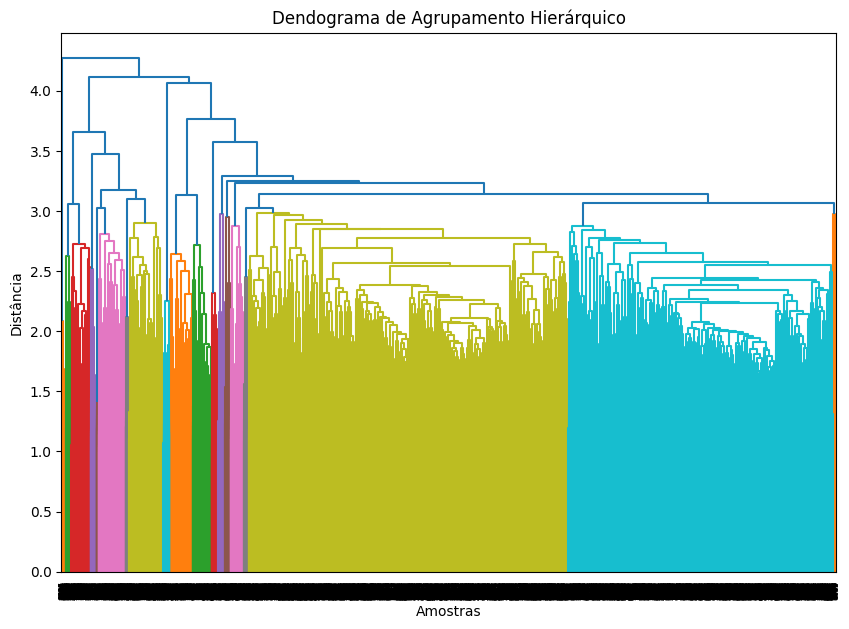

In [ ]:
# Calculando as ligações para o dendograma
linkage_mode = 'ward'
hierarchical_model = AgglomerativeClustering(n_clusters=7, linkage=linkage_mode)
Z = linkage(X2, method=linkage_mode)

# Plotando o dendograma
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendograma de Agrupamento Hierárquico')
plt.xlabel('Amostras')
plt.ylabel('Distância')
plt.show()

### Agrupamento Espectral

Usando o número de classes que econtramos usando o agrupamento hierárquico treinamos o agrupamento hierárquico.

In [ ]:
from sklearn.cluster import SpectralClustering

n_clusters = 7
modelo_espectral = SpectralClustering(n_clusters=n_clusters, affinity='rbf', random_state=42, assign_labels='cluster_qr')

### k-means

A mesma heurística aplicada no agrupamento espectral vale para o kmeans

In [ ]:
#kmeans
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 7, n_init = 5)
kmeans.fit_predict(X2)

array([4, 4, 4, ..., 4, 0, 4], dtype=int32)

## Vamos avaliar o desempenho dos modelos

Na avaliação dos modelos a porção de teste dos dados é utilizada. Aplicamos o mesmo vectorizer e o mesmo PCA usados para o pré-processamento dos dados de treino. Na avaliação olhamos a acurácia e o F1-Score. Uma matriz de confusão também é usada para demonstrar quais classes o classificador mais acertou.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

rand_X_test_tfidf = vectorizer.transform(rand_X_test)
test_data_frame = pd.DataFrame(rand_X_test_tfidf.todense(), columns = vectorizer.get_feature_names_out())

def avaliar_clustering_com_classificacao(model, pca, test_data_frame, dict_class_to_cluster, X, y):
    X_test = pca.fit_transform(test_data_frame)
    y_pred = model.fit_predict(X_test)
    y_true = y.map(dict_class_to_cluster)

    # Calculando métricas de avaliação
    scores = {
        'Acurácia': accuracy_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred, average='weighted')
    }

    # Imprimindo as métricas
    for nome, valor in scores.items():
        print(f"{nome}: {valor}")

    # Matriz de Confusão
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.title('Matriz de Confusão')
    plt.show()

    return scores


### Hierárquico

O agrupamento hierárquico ao ser avaliado pelo dendograma aparenta ser uma boa opção para agrupamento. Mas teve um desempenho bem ruim olhando para as métricas de acurácia e f1 score. Porém, a distribuição dos grupos seguiu o dendograma, um grupo muito grande que o hierárquico conseguiu identificar e o segundo maior grupo ficam muito evidentes na matriz de confusão.

Acurácia: 0.23125576492291475
F1-Score: 0.1702496761537913


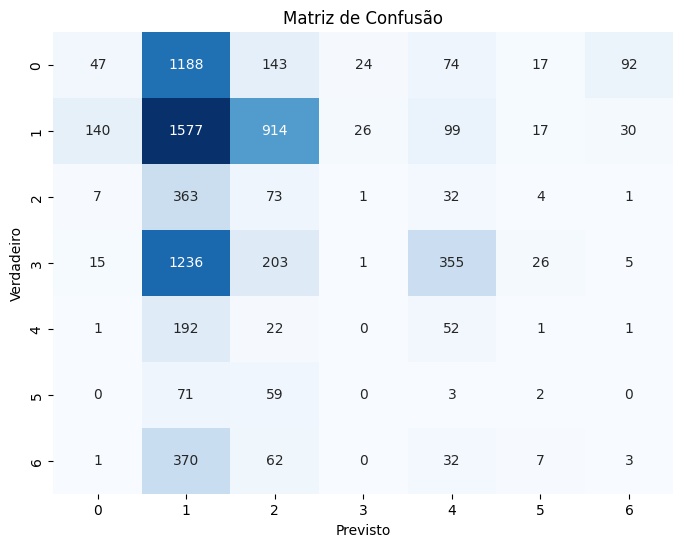

{'Acurácia': 0.23125576492291475, 'F1-Score': 0.1702496761537913}

In [ ]:
# Avaliando o modelo com rótulos verdadeiros
avaliar_clustering_com_classificacao(hierarchical_model, pca, test_data_frame, dicionario_generos_para_clusters, rand_X_test, rand_y_test)

### Espectral

O algoritmo espectral chega a ser bem melhor (comparado com o resultado dos outros). O resulto segue uma distribuição mais uniformizada ao observarmos a matriz de confusão e constatar que o algoritmo classificou mais itens em outros clusters. Difetentemente do hierárquico que classificou muitos itens em dois grupos.

Acurácia: 0.12188694162603769
F1-Score: 0.12972488896710832


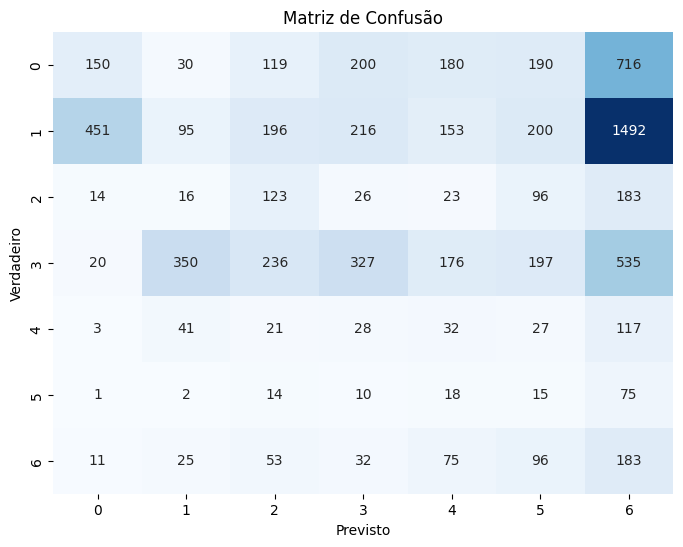

{'Acurácia': 0.12188694162603769, 'F1-Score': 0.12972488896710832}

In [ ]:
# Avaliando o modelo com rótulos verdadeiros
avaliar_clustering_com_classificacao(modelo_espectral, pca, test_data_frame, dicionario_generos_para_clusters, rand_X_test, rand_y_test)

### k-means

Não conseguimos minimizar o erro do kmeans para escolher um k, mas colocamos aqui no trabalho pois foi usado.

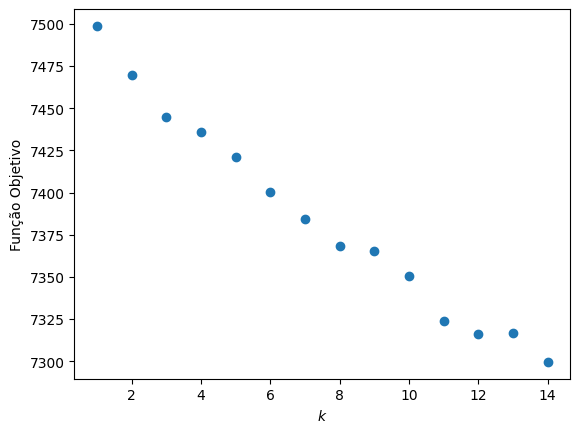

In [ ]:
from sklearn import cluster

inertia = []
for i in range(1, 15):
  km = cluster.KMeans(n_clusters = i)
  km.fit(rand_X_tfidf)
  inertia.append(km.inertia_)

plt.scatter(range(1, 15), inertia)
_ = plt.ylabel("Função Objetivo")
_ = plt.xlabel(r"$k$")

Acurácia: 0.12188694162603769
F1-Score: 0.1297228307448704


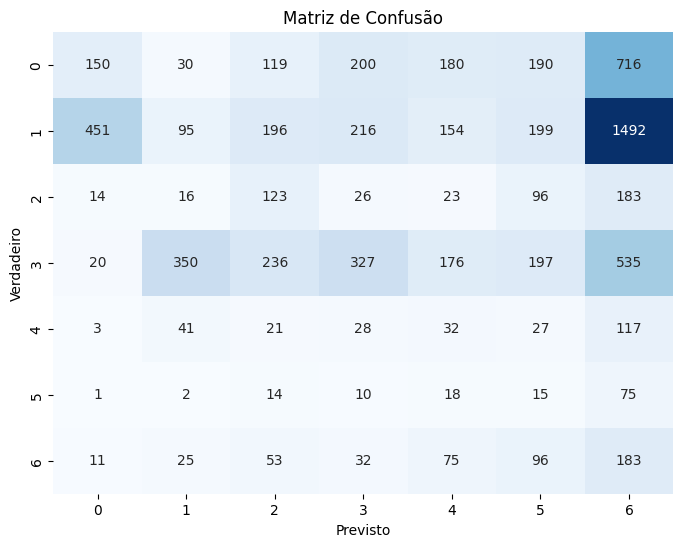

{'Acurácia': 0.12188694162603769, 'F1-Score': 0.1297228307448704}

In [ ]:
avaliar_clustering_com_classificacao(modelo_espectral, pca, test_data_frame, dicionario_generos_para_clusters, rand_X_test, rand_y_test)

## Resultados de validação

1. Como foi escolhido o número de componentes principais para o PCA? O número de componentes principais tem um impacto significativo nos resultados? É necessário usar PCA neste trabalho?

Usamos o gráfico mostrado em aula para decidir o número de componentes. O PCA não teve uma grande redução no nosso conjunto, mas eu não deixaria de usar pois reduz um pouco a quantida de de dimensões melhorando o resultado dos classificadores.

2. Como o número de grupos para cada algoritmo de agrupamento foi definido? A escolha do algoritmo de agrupamento impacta significativamente os resultados? E o número de grupos?

A escolha do número de grupos foi baseada no dendograma do agrupamento hierárquico, onde identificamos aproximadamente 7 grupos.
A escolha impacta sim, um exemplo é o hierárquico, só mudando o tipo de ligação ele já não não conseguem formar bem os grupos.

## Análise

Após validar e entender os resultados (e se convencerem que estão corretos e fazem sentido), você deve responder as perguntas principais:
- Há diferença nas distribuições de gêneros dos filmes em grupos diferentes?

  Sim, tem diferença na proporção dos grupos ao olhar a matriz de confusão é possível perceber que alguns grupos classificados são muito mais densos, e com filmes de diferentes gêneros.

- Há relação entre as sinopses dos filmes e os respectivos gêneros?

A escolha do número de grupos foi baseada no dendograma do agrupamento hierárquico, onde identificamos aproximadamente 7 grupos.
O resultado é impactado pela mudança de algoritmo, o mesmo número de grupos gerou diferentes resultados.
A escolha impacta a quantidade de grupos, um exemplo é o hierárquico, só mudando o tipo de ligação ele já não não conseguem formar bem os grupos.

## Integrantes


* Alex - alex.s.oliveira@edu.ufes.br   - 2019108696

* Dionatas - dionatas.brito@edu.ufes.br - 2019202307

## Referências

- Lista de [stopwords](https://github.com/igorbrigadir/stopwords/blob/21fb2ef149216e3c8cac097975223604ae1e2310/en/rouge_155.txt) que encontramos na documentação do Scikitlearn
- https://scikit-learn.org/stable/index.html